In [1]:
from openai import OpenAI
import os
import tiktoken
from tqdm import tqdm
import PyPDF2
import re
import pandas as pd
from typing import List, Tuple, Optional
from pydantic import BaseModel
import numpy as np
from textwrap import dedent

import pandas as pd
from rouge_score import rouge_scorer
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import numpy as np

In [2]:
OpenAI.api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI()
MODEL = 'gpt-4o-mini'

In [2]:
def read_pdf(file_path):
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        text = ''
        for page in range(len(reader.pages)):
            text += reader.pages[page].extract_text()
                    
        text = re.sub(r'Indian Kanoon - http://indiankanoon.org/doc/\d+/ \d', '', text)
        text = re.sub(r'http://www.judis.nic.in', '', text)
    
        return text

In [4]:
extracted = pd.read_csv('../sheets/extracted/openai_extracted.csv', index_col=0)
extracted

,file_name,summary,court,petitioners,respondents,judges,date,org,gpe,provisions,statutes,precedents,key_facts,type_of_case,decision
0,Abhijeet_Suryakant_Maske_And_Anr_vs_The_State_...,In the case of Abhijeet Suryakant Maske and An...,HIGH COURT OF JUDICATURE AT BOMBAY,"['Abhijeet Suryakant Maske', 'Dilip Ramchandra...",['The State of Maharashtra'],['C.V. Bhadang'],01-03-2022,[],"['Pune', 'Maharashtra']","['Section 328 of IPC', 'Section 272 of IPC', '...","['Food Safety and Standards Act, 2006']","['Joseph Kurian & Anr. Vs. State of Kerala', '...",The Applicants are seeking anticipatory bail i...,Anticipatory Bail Application,in favour of appellant
1,Amluya_Anand_vs_State_on_8_March_2022.PDF,**Case Summary: Amluya Anand vs State (8 March...,HIGH COURT OF JUDICATURE FOR RAJASTHAN AT JODHPUR,['Amluya Anand'],"['State, Through Vinod Sharma, Food Safety Off...",['Sandeep Mehta'],08-03-2022,"['Amul Dairy', 'Food Safety Officer', 'Chief M...","['Mujjafarpur', 'Gurgaon', 'Nagaur', 'Devgarh ...","['Section 468 of Cr.P.C.', 'Section 77 of the ...","['Food Safety and Standards Act, 2006']",['Sri.V.V.S.S.R. Prakash Rao vs. The State of ...,The petitioner sought to quash orders taking c...,Criminal Miscellaneous Petition,in favour of appellant
2,Arulmurugan_Starch_Industries_vs_Food_Safety_A...,**Case Summary: Arulmurugan Starch Industries ...,High Court of Judicature at Madras,['Arulmurugan Starch Industries'],['Food Safety and Standards Authority of India...,['Krishnan Ramasamy'],19-01-2022,['Food Safety and Standards Authority of India...,"['Salem District', 'New Delhi', 'Chennai']",['Article 226 of the Constitution of India'],"['Food Safety and Standards Act, 2006']",[],The petitioner filed a writ petition challengi...,Writ Petition,The court directed the Commissioner of Food Sa...
3,Arun_Raosaheb_Khot_vs_State_Of_Maharashtra_on_...,In the case of Arun Raosaheb Khot vs. State of...,High Court of Judicature at Bombay,['Arun Raosaheb Khot'],['The State of Maharashtra'],['C.V. Bhadang'],31-01-2022,[],"['Pune', 'Maharashtra']","['Section 272 of IPC', 'Section 273 of IPC', '...","['Food Safety and Standards Act, 2006']",['Joseph Kurian & Anr. Vs. State of Kerala'],The applicant is seeking anticipatory bail in ...,Anticipatory Bail Application,in favour of appellant
4,Asha_Singh_vs_The_State_Of_Bihar_on_24_March_2...,In the case of Asha Singh vs The State of Biha...,HIGH COURT OF JUDICATURE AT PATNA,['Asha Singh'],"['The State of Bihar', 'THE UNION OF INDIA THR...",['Ashutosh Kumar'],24-03-2022,"['Tata Institute of Social Sciences', 'SAKHI']","['Bihar', 'Patna', 'East Champaran', 'Motihari']","['Section 341 of IPC', 'Section 342 of IPC', '...","['Indian Penal Code', 'Protection of Children ...",[],"The petitioner, Asha Singh, is seeking anticip...",Criminal Miscellaneous,against appellant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191,Vijaysing_Dnyaneshwar_Gotya_S_O_vs_State_Of_Mh...,**Case Summary: Vijaysing @ Dnyaneshwar @ Goty...,"High Court of Judicature at Bombay, Nagpur Bench",['Vijaysing @ Dnyaneshwar @ Gotya Raghunandan ...,['State of Maharashtra'],['Avinash G. Gharote'],13-01-2022,[],"['Maharashtra', 'Mumbai']","['Section 188 of IPC', 'Section 272 of IPC', '...","['Food Safety and Standard Act 2006', 'Cigaret...",['Ganesh Pandurang Jadhao vrs. State of Mahara...,The applicant was arrested for transporting co...,Criminal Application (Bail),against appellant
192,Viky_Vikash_Ku_Agrawal_vs_State_Of_Odisha_Opp_...,In the case of Viky @ Vikash Ku Agrawal vs Sta...,High Court of Orissa at Cuttack,['Viky @ Vikash Ku Agrawal'],['State of Odisha'],['S.K. Sahoo'],09-02-2022,[],"['Odisha', 'Kantabanji']","['Section 438 of Cr.P.C.', 'Section 272 of IPC...","['Indian Penal Code', 'Food Safety and Standar...",[],The petitioner applied for anticipatory bail i...,Anticipatory bail application,in favour of appellant
193,Vishnu_Gupta_Lalla_vs_The_State_Of_Madhya_Prad...,"On January 3, 2022, the High Court of Madhya P...",High Cour

In [5]:
#calculate average BERT and ROUGE-L scores

def calculate_scores(extracted: pd.DataFrame) -> pd.DataFrame:
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    tokenizer = BertTokenizer.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
    model = BertForSequenceClassification.from_pretrained('nlptown/bert-base-multilingual-uncased-sentiment')
    model.eval()
    scores = []
    for index, row in tqdm(extracted.iterrows()):
        text = read_pdf(f'../Docs/food-safety/{row["file_name"]}')
        summary = row['summary']
        inputs = tokenizer(text, summary, return_tensors='pt', max_length=512, truncation=True, padding='max_length')
        with torch.no_grad():
            outputs = model(**inputs)
        scores.append({
            'bert_score': outputs.logits[0].numpy(),
            'rougeL_score': scorer.score(text, summary)['rougeL'].fmeasure
        })
    return pd.concat([extracted, pd.DataFrame(scores)], axis=1)

scores = calculate_scores(extracted)




Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

C:\Users\suyog\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\transformers\modeling_utils.py:461: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any

In [12]:
scores['bert_score'].mean()

array([ 0.6241578 , -0.22377542, -0.5008658 , -0.10785933,  0.14484897],
      dtype=float32)

In [11]:
scores['rougeL_score'].mean()

0.27563639181933824

In [4]:
docs = os.listdir('../Docs/food-safety')
token_lengths = pd.DataFrame(columns=['doc', 'token_length'])
for doc in tqdm(docs):
    try:
        text = read_pdf(f'../Docs/food-safety/{doc}')
    except Exception as e:
        # print(f'Error reading {doc}')
        # os.remove(f'../Docs/fs_cases/{doc}')
        continue
    encoding = tiktoken.encoding_for_model('gpt-4o-mini')
    if len(encoding.encode(text)) > 120000:
        print(f'{doc} is too long')
    token_lengths.loc[len(token_lengths)] = [doc, len(encoding.encode(text))]

  0%|          | 0/197 [00:00<?, ?it/s]

 54%|█████▍    | 106/197 [00:14<00:19,  4.64it/s]

M_S_Lg_Electronics_India_Pvt_Ltd_vs_The_State_Of_Tamil_Nadu_on_31_March_2022.PDF is too long


100%|██████████| 197/197 [00:19<00:00, 10.13it/s]


In [18]:
lengths = token_lengths['token_length'].values
lengths = lengths.tolist()
lengths.remove(np.max(lengths))
np.mean(lengths), np.std(lengths), np.max(lengths), np.min(lengths), np.median(lengths), np.sum(lengths), np.count_nonzero(lengths)

(5064.65306122449, 9909.777865775864, 53941, 453, 1121.0, 992672, 196)

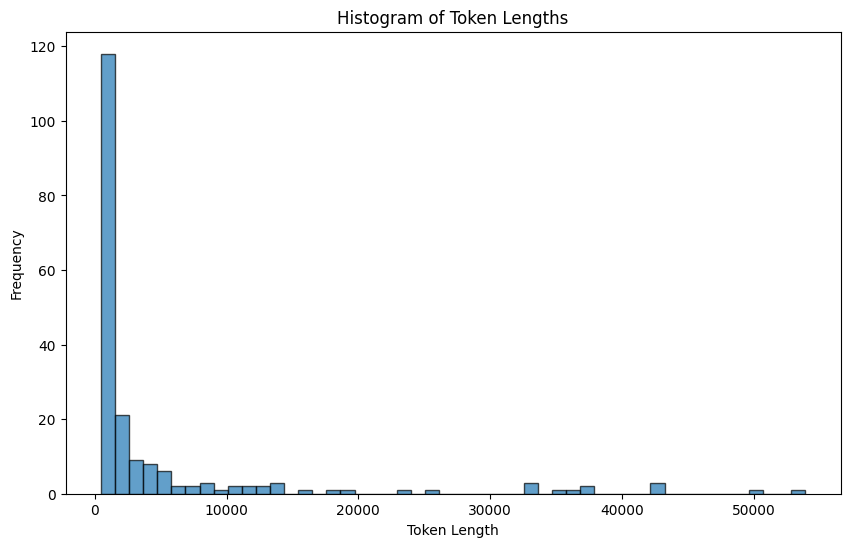

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming lengths is already defined
lengths = token_lengths['token_length'].values
lengths = lengths.tolist()
lengths.remove(np.max(lengths))

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=50, edgecolor='k', alpha=0.7)
plt.title('Histogram of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

# # Box Plot
# plt.figure(figsize=(10, 6))
# sns.boxplot(lengths)
# plt.title('Box Plot of Token Lengths')
# plt.xlabel('Token Length')
# plt.show()

# # Violin Plot
# plt.figure(figsize=(10, 6))
# sns.violinplot(lengths)
# plt.title('Violin Plot of Token Lengths')
# plt.xlabel('Token Length')
# plt.show()

# # KDE Plot
# plt.figure(figsize=(10, 6))
# sns.kdeplot(lengths, shade=True)
# plt.title('KDE Plot of Token Lengths')
# plt.xlabel('Token Length')
# plt.ylabel('Density')
# plt.show()

In [29]:
import numpy as np

# Assuming lengths is already defined
lengths = token_lengths['token_length'].values
lengths = lengths.tolist()
lengths.remove(np.max(lengths))

# Calculate histogram data
counts, bins = np.histogram(lengths, bins=80)

# Save histogram data to a file
with open('histogram_data.dat', 'w') as f:
    f.write("BinStart,BinEnd,Count\n")
    for i in range(len(counts)):
        f.write(f"{bins[i]},{bins[i+1]},{counts[i]}\n")

In [ ]:
completion = client.beta.chat.completions.parse(
        model="gpt-4o-mini",
        temperature=0.0,
        messages=[
            {"role": "system", "content": dedent(extraction_prompt)},
            {"role": "user", "content": text}
        ],
        response_format=EntityExtraction,
    )

out = completion.choices[0].message

In [10]:
summarization_prompt = '''
    You will be provided with a legal judgement of a food safety-related case.
    Your goal is to provide a detailed summary of the judgement.
    Only include information explicitly stated in the document. Do not infer, interpret, or add new information. Use concise language while preserving all critical legal details, such as statute names, provisions, case outcomes, and involved parties.
    Organize the summary logically, grouping related points. For example:

       - Case overview
       - Key facts
       - Legal issues and arguments
       - Court's reasoning
       - Decision or judgment
    
    Return plain text, do not include any markdown or HTML formatting.
       
    Here is a description of the parameters:
    - summary: a detailed summary of the judgement, following the guide above. 
'''

class ArticleSummary(BaseModel):
    summary: str

def get_summary(text: str):
    completion = client.beta.chat.completions.parse(
        model=MODEL,
        temperature=0.0,
        messages=[
            {"role": "system", "content": dedent(summarization_prompt)},
            {"role": "user", "content": text}
        ],
        response_format=ArticleSummary,
    )

    return completion.choices[0].message.parsed


In [11]:
extraction_prompt = '''
    You will be provided with a legal judgement of a food safety-related case.
    Your goal is to extract key information following the schema provided.
    Please ensure that the extracted information is accurate and complete.
    
    Any references to the Food Safety and Standards Act should be extracted as "Section x of the Food Safety and Standards Act, 2006" or "Food Safety and Standards Act, 2006".
    Always use full forms of abbreviations, e.g. "Supreme Court" instead of "SC", or "Indian Penal Code" instead of "IPC".
    Names of courts should be standardized and follow correct capitalization, e.g. "Supreme Court of India", "High Court of Delhi", NOT "Supreme Court", "Delhi High Court" or "DELHI HIGH COURT". 
    
    Here is a description of the parameters:
    - court: name of the court that issued the judgement.
    - petitioners: array of strings containing the names of ALL appellant(s) in the case.
    - respondents: array of strings containing the names of ALL respondent(s) in the case.
    - judges: array of strings containing the names of the judge(s) in the case.
    - date: date of the judgement, as a string in the format "DD-MM-YYYY".
    - org: array of strings containing the names of all organizations, companies, or government entities mentioned in the case, if any.
    - gpe: array of strings containing the names of all geographical locations mentioned in the case, if any.
    - provisions: array of strings containing the provisions of ALL statutes cited in the judgement. Provide these in the format "Section x of y". In case of references to multiple sections of the same statute, list them all separately.
    - statutes: array of strings containing the names of ALL acts or laws cited in the judgement.
    - precedents: array of strings containing the names of ALL precedents cited in the judgement.
    - key_facts: key facts about the case. This should be very concise, and include the background of the case, and the main arguments made by both parties. If no information is provided, leave this field empty.
    - type_of_case: the type of case, e.g. bail application, civil appeal, criminal appeal, public interest litigation, etc.
    - decision: the decision of the court in the case, if provided. If there is a verdict, respond with 'in favour of appellant' or 'in favour of respondent'. If not, leave this field empty.
'''

class EntityExtraction(BaseModel):
    court: str
    petitioners: list[str]
    respondents: list[str]
    judges: list[str]
    date: str
    org: list[str]
    gpe: list[str]
    provisions: list[str]
    statutes: list[str]
    precedents: list[str]
    key_facts: str
    type_of_case: str
    decision: str

def get_key_info(text: str):
    completion = client.beta.chat.completions.parse(
        model=MODEL,
        temperature=0.0,
        messages=[
            {"role": "system", "content": dedent(extraction_prompt)},
            {"role": "user", "content": text}
        ],
        response_format=EntityExtraction,
    )

    return completion.choices[0].message.parsed

In [12]:
def print_entities(extracted):
    print(f"Court: {extracted.court}")
    print(f"Petitioners: {', '.join(extracted.petitioners)}")
    print(f"Respondents: {', '.join(extracted.respondents)}")
    print(f"Judges: {', '.join(extracted.judges)}")
    print(f"Date: {extracted.date}")
    print(f"Organizations: {', '.join(extracted.org)}")
    print(f"Locations: {', '.join(extracted.gpe)}")
    print(f"Provisions: {', '.join(extracted.provisions)}")
    print(f"Statutes: {', '.join(extracted.statutes)}")
    print(f"Precedents: {', '.join(extracted.precedents)}")
    print(f"Key Facts: {extracted.key_facts}")
    print(f"Decision: {extracted.decision}")
    
def save_output_to_df(file_name, summary, extracted, df):
    df.loc[len(df)] = [file_name, summary.summary, extracted.court, extracted.petitioners, extracted.respondents, extracted.judges, extracted.date, extracted.org, extracted.gpe, extracted.provisions, extracted.statutes, extracted.precedents, extracted.key_facts, extracted.type_of_case, extracted.decision]
    return df

In [13]:
def read_single_pdf(path):
    reader = PyPDF2.PdfReader(path)
    text = ''
    for page in range(len(reader.pages)):
        text += reader.pages[page].extract_text()
    
    text = re.sub(r'Indian Kanoon - http://indiankanoon.org/doc/\d+/ \d', '', text)
    text = re.sub(r'http://www.judis.nic.in', '', text)
    
    return text

In [20]:
files = os.listdir('../Docs/fs_cases')
#limit to 200 files
files = files[:250]
df = pd.DataFrame(columns=['file_name', 'summary', 'court', 'petitioners', 'respondents', 'judges', 'date', 'org', 'gpe', 'provisions', 'statutes', 'precedents', 'key_facts', 'type_of_case', 'decision'])
errs = []
for i in tqdm(files):
    try:
        text = read_single_pdf(f'../Docs/fs_cases/{i}')
        summary = get_summary(text)
        extracted = get_key_info(text)
        df = save_output_to_df(i, summary, extracted, df)
        df.to_csv('food_safety_newdocs.csv', index=False)
    except Exception as e:
        print(f'Error with {i}: {e}')
        errs.append(i)
        continue
    

 43%|████▎     | 107/250 [15:10<2:37:23, 66.04s/it]

Error with Jagdish_Prasad_Sharma_vs_Commissioner_Of_Food_Safety_Lucknow_on_2_May_2014.PDF: Could not parse response content as the length limit was reached - CompletionUsage(completion_tokens=16384, prompt_tokens=12054, total_tokens=28438, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=11904))


100%|██████████| 250/250 [37:02<00:00,  8.89s/it]  


In [22]:
#only keep rows that have statutes extracted

df_clean = df[df['provisions'].apply(lambda x: len(x) > 0)]
df_clean

,file_name,summary,court,petitioners,respondents,judges,date,org,gpe,provisions,statutes,precedents,key_facts,type_of_case,decision
0,8_vs_Wood_Craft_Products_1995_on_21_February_2...,Case overview\nThe case involves an appeal by ...,High Court of Kerala,[M/S.PARISONS FOODS PVT. LTD.],[JOINT COMMISSIONER OF COMMERCIAL TAXES],"[K.Vinod Chandran, Ashok Menon]",18-01-2018,[],"[Kerala, Thiruvananthapuram, Calicut]","[Section 94 of Kerala Value Added Tax Act, 2003]","[Kerala Value Added Tax Act, 2003, Food Safety...",[M.P. Agencies v. State of Kerala - 2015 (7) S...,The case involves a dispute over the tax class...,Other Tax Appeal,in favour of respondent
2,Aditya_Birla_Retail_Ltd_Ludhiana_vs_Food_Safet...,Case overview\n- The case is between M/s Adity...,High Court of Punjab and Haryana,"[M/s Aditya Birla Retail Limited, Ludhiana]","[The Food Safety Officer, Ludhiana]",[Kuldip Singh],14-03-2018,[],"[Ludhiana, Chandigarh]",[Section 51 of the Food Safety and Standards A...,"[Food Safety and Standards Act, 2006]",[],The appellant was penalized for possessing art...,Second Appeal,in favour of respondent
4,Akuthota_Narasimha_vs_The_State_Of_Telangana_o...,Case overview\n- The case is Akuthota Narasimh...,High Court of Telangana,[Akuthota Narasimha],"[The State Of Telangana, respondent No.2, resp...",[Sri Justice T. Amarnath Goud],22-06-2021,[Sai Enterprises],"[Karnataka State, Nalgonda District]",[Section 30(2)(e) of Food Safety and Standards...,"[Food Safety and Standards Act, 2006]",[],The petitioner challenged a penalty of Rs.1 la...,Writ Petition,in favour of respondent
6,Alpeshbhai_Babubhai_Pathodiya_vs_State_Of_Guja...,Case overview\n- The case involves Alpeshbhai ...,High Court of Gujarat,[Alpeshbhai Babubhai Pathodiya],[State of Gujarat],"[Mohinder Pal, A.C. Rao]",04-12-2018,[],"[Gujarat, Ahmedabad, Surendranagar, Gandhinagar]","[Section 49 of Food Safety and Standards Act, ...","[Food Safety and Standards Act, 2006]",[],The petitioner challenged the penalty of Rs.2 ...,First Appeal,in favour of respondent
7,Amar_Kumar_Khabare_Amar_Khabare_vs_The_State_O...,Case overview\n- The case is Amar Kumar Khabar...,High Court of Jharkhand,[Amar Kumar Khabare @ Amar Khabare],"[The State of Jharkhand, The Deputy Commission...",[Sujit Narayan Prasad],01-05-2019,[],"[Jharkhand, Deoghar]",[Section 3(J) of Food Safety and Standards Act...,"[Food Safety and Standards Act, 2006, Food Saf...",[Shri Bhagwan Naidu vs. The State of Jharkhand...,The petitioner challenged the order imposing a...,Writ Petition,"The Deputy Commissioner, Deoghar will take a f..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,Sageer_Ahmad_vs_State_Of_U_P_And_3_Others_on_1...,Case overview\n- Case Title: Sageer Ahmad vs S...,High Court of Judicature at Allahabad,[Sageer Ahmad],[State Of U.P. And 3 Others],"[Sunita Agarwal, Deepak Verma]",15-03-2021,[],[Prayagraj],"[Section 51 of Food Safety and Standards Act, ...","[Food Safety and Standards Act, 2006]",[],The petitioner challenged a recovery citation ...,Writ Petition,in favour of respondent
244,Sambhagiye_Nagrik_Upbhokta_vs_Union_Of_India_o...,Case overview\n- The case is a Public Interest...,High Court of Madhya Pradesh,[Sambhagiye Nagrik Upbhokta Margdarshan Manch],"[Union of India, State of Madhya Pradesh]","[Hon. Shri Justice S.K.Gangele, Hon. Shri Just...",01-10-2014,[],"[Madhya Pradesh, Bhopal, Ujjain, Indore]","[Section 2 of Food Safety and Standards Act, 2...","[Food Safety and Standards Act, 2006, Food Saf...",[],The petitioner filed a Public Interest Litigat...,Public Interest Litigation,in favour of petitioner
245,Samsher_Gani_vs_State_Of_Uttarakhand_Others_on...,Case overview\n- The case is titled Samsher Ga...,High Court of Uttarakhand,[Samsher Gani],"[State Of Uttarakhand, Adjudicating Officer, H...",[U. C. Dhyani],24-03-2015,[],"[Uttarakhand, Dehradun, Haldwani, Haridwar]","[Section 51 of Food Safety and Standards Act, ...","[Food Safety and Standards Act, 2006, Food Saf...",[],The p